**ФЕДЕРАЛЬНОЕ АГЕНСТВО ЖЕЛЕЗНОДОРОЖНОГО ТРАНСПОРТА**

Федеральное государственное бюджетное образовательное учреждение высшего образования

«ПЕТЕРБУРГСКИЙ ГОСУДАРСТВЕННЫЙ УНИВЕРСИТЕТ ПУТЕЙ СООБЩЕНИЯ Императора Александра I»

---

**Кафедра «Информационные и вычислительные системы»**

Дисциплина «Архитектура вычислительных систем»

**ОТЧЁТ**

**ПО ЛАБОРАТОРНОЙ РАБОТЕ №3**

**«ИССЛЕДОВАНИЕ ПРОЦЕССОРНЫХ АРХИТЕКТУР КЛАССА SIMD»**

---

Выполнил студент

Факультет: АИТ

Группа: ИВБ-211

А. Шефнер

---

Проверил:	В.А. Гончаренко

# Цель занятия

Изучение принципов организации и функционирования вычислительных систем
класса SIMD, исследование векторно-конвейерных процессоров, матричных и
ассоциативных структур, а также систолических массивов, освоение методик
оценки их производительности.

# Ход работы

Импорты для всего блокнота

In [1]:
from dataclasses import asdict, dataclass, is_dataclass
from math import sqrt
from random import randint

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from IPython.display import HTML

Функции отображения табличных данных

In [2]:
def render_cell(cell):
    if cell is None:
        cell = "-"
    return f"        <td>{cell}</td>\n"


def display_table_lists(data, headers=None):
    result = "<table>\n"

    if headers:
        result += "  <thead>\n"
        result += "    <tr>\n"
        for header in headers:
            result += f"      <th>{header}</th>"
        result += "    </tr>\n"
        result += "  </thead>\n"

    result += "  <tbody>\n"
    for row in data:
        result += "    <tr>\n"

        if is_dataclass(row):
            for key, value in asdict(row).items():
                result += render_cell(value)
        else:
            for cell in row:
                result += render_cell(cell)

        result += "    </tr>\n"
    result += "  </tbody>\n"
    result += "</table>\n"
    display(HTML(result))


def display_table_dicts(data, headers=None):
    keys = list(data[0].keys())
    data = [[dic[key] for key in dic] for dic in data]
    headers = headers if headers else keys
    display_table_lists(data, headers)


def display_table_dataclasses(data, headers=None):
    display_table_dicts([asdict(obj) for obj in data], headers)


def display_table(data, headers=None):
    first = data[0]
    if isinstance(first, list):
        display_table_lists(data, headers)
    elif isinstance(first, dict):
        display_table_dicts(data, headers)
    elif is_dataclass(first):
        display_table_dataclasses(data, headers)
    else:
        raise ValueError("Unsupported type")

## Исходные данные по варианту

In [3]:
@dataclass
class VariantData:
    # Размер вектора N
    vector_size: int

    # Размер матрицы M
    matrix_size: int

    # Число процессорных элементов P
    processor_count: int

    # Число ступеней конвейера K
    step_count: int

    # Время такта t (нс)
    cycle_time: int

    # Размерность решетки R
    grid_size: int

    # Число ячеек ассоциативной памяти n
    cell_count: int

    # Ассоциативный признак P
    assoc_tag: int

    # Коэффициент сложности K_ас
    complexity: int

    # Размер систолического массива L
    systolic_array_size: int


def get_variant_data(group, number):
    g = int(group[-3:])
    s = number % 100
    return VariantData(
        vector_size=50 + g % 50,
        matrix_size=10 + s % 10,
        processor_count=4 + g % 8,
        step_count=3 + s % 5,
        cycle_time=1 + s % 10,
        grid_size=2 + g % 3,
        cell_count=16 + (g % 16) * 4,
        assoc_tag=s % 16,
        complexity=2 + s % 3,
        systolic_array_size=3 + s % 4,
    )


d = get_variant_data("ИВБ-211", 13)
display_table([d])

vector_size,matrix_size,processor_count,step_count,cycle_time,grid_size,cell_count,assoc_tag,complexity,sistolic_array_size
61,13,7,6,4,3,28,13,3,4


## Задание 1. Исследование векторно-конвеерного процессора

In [4]:
@np.vectorize
def t1_n(n):
    return (n + d.step_count - 1) * d.cycle_time


@np.vectorize
def t2_n(n):
    return (n * 0.5 + d.step_count - 1) * d.cycle_time


display(f"N = {d.vector_size}")
display(f"T1 = {t1_n(d.vector_size)}")
display(f"T2 = {t2_n(d.vector_size)}")

'N = 61'

'T1 = 264'

'T2 = 142.0'

Эффективность ускорения при различных размерах вектора

In [5]:
display_table(
    [[n, t1_n(n), t2_n(n), t1_n(n) / t2_n(n)] for n in [10, 50, 100, 500, 1000]],
    ["N", "T1", "T2", "Ускорение"],
)

N,T1,T2,Ускорение
10,60,40.0,1.5
50,220,120.0,1.8333333333333333
100,420,220.0,1.9090909090909092
500,2020,1020.0,1.9803921568627452
1000,4020,2020.0,1.99009900990099


### График зависимости времени выполнения от N

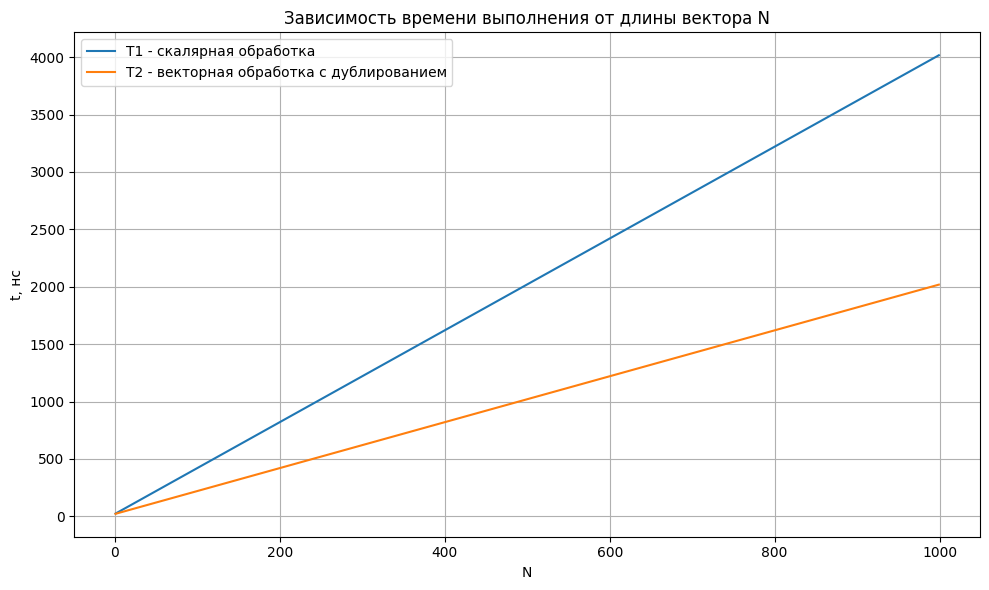

In [6]:
n = np.arange(1, 1000)

plt.figure(figsize=(10, 6))
plt.plot(n, t1_n(n), label="T1 - скалярная обработка")
plt.plot(n, t2_n(n), label="T2 - векторная обработка с дублированием")

plt.title("Зависимость времени выполнения от длины вектора N")
plt.xlabel("N")
plt.ylabel("t, нс")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

### График зависимости ускорения от N

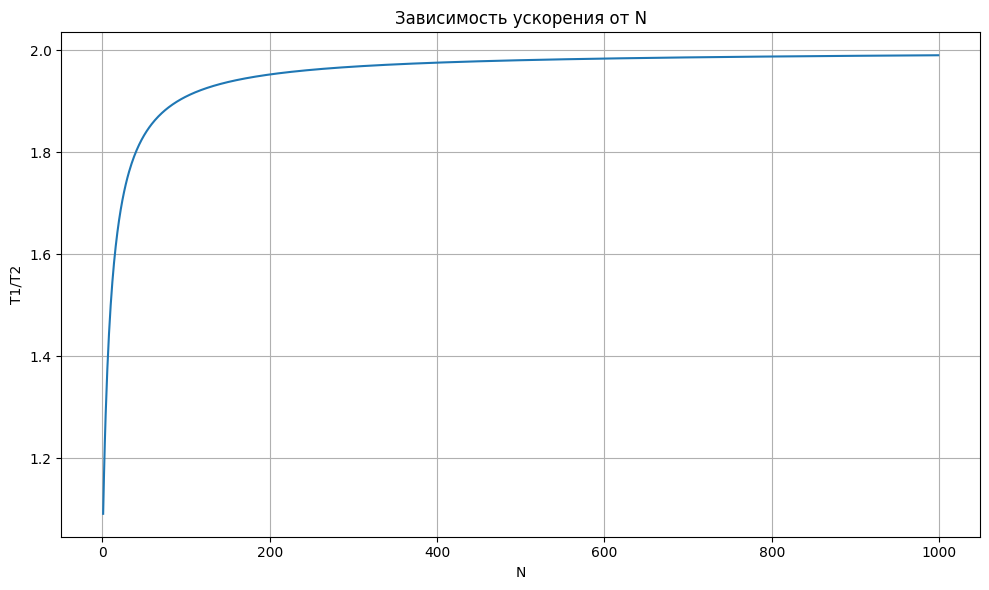

In [7]:
n = np.arange(1, 1000)

plt.figure(figsize=(10, 6))
plt.plot(n, t1_n(n) / t2_n(n))

plt.title("Зависимость ускорения от N")
plt.xlabel("N")
plt.ylabel("T1/T2")
plt.grid()
plt.tight_layout()

plt.show()

### Выводы

При маленьких размерах вектора ($N<10$) ускорение весьма несущественное; при стремлении N к бесконечности ускорение быстро приближается к 2 
($N \rightarrow \infty; \frac{T_1}{T_2} \rightarrow 2$)
и даёт значительное ускорение.

## Задание 2. Исследование матричной SIMD-системы

Размерность матрицы:

In [8]:
m_size = round(sqrt(d.processor_count))
display(f"a = b = {m_size}")

'a = b = 3'

### Схема матричного процессора

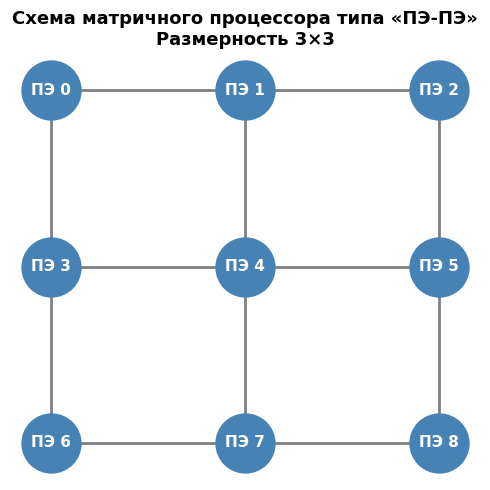

In [9]:
a = b = m_size

G = nx.grid_2d_graph(a, b)
pos = {(i, j): (j, -i) for i, j in G.nodes()}
labels = {(i, j): f"ПЭ {i*b + j}" for i, j in G.nodes()}

plt.figure(figsize=(5, 5))
plt.title(
    f"Схема матричного процессора типа «ПЭ-ПЭ»\nРазмерность {a}×{b}",
    fontsize=13,
    fontweight="bold",
)

nx.draw(
    G,
    pos=pos,
    labels=labels,
    with_labels=True,
    node_color="steelblue",
    node_size=1800,
    font_color="white",
    font_size=11,
    font_weight="bold",
    edge_color="gray",
    width=2,
)

plt.tight_layout()
plt.savefig("matrix_simd.png", dpi=150)
plt.show()

### Таблица решётки

Вычисление данных для отрисовки

In [10]:
grid = [
    [0, 1, 2],
    [3, 4, 5],
    [6, 7, 8],
]


@dataclass
class ProcessorInfo:
    number: int
    x: int
    y: int
    neighbor_left: int | None
    neighbor_right: int | None
    neighbor_top: int | None
    neighbor_bottom: int | None


data = []
for y, row in enumerate(grid):
    for x, cell in enumerate(row):
        info = ProcessorInfo(
            number=cell,
            x=x,
            y=y,
            neighbor_left=None if x == 0 else grid[y][x - 1],
            neighbor_right=None if x == len(row) - 1 else grid[y][x + 1],
            neighbor_top=None if y == 0 else grid[y - 1][x],
            neighbor_bottom=None if y == len(grid) - 1 else grid[y + 1][x],
        )
        data.append(info)

Итоговая таблица

In [11]:
display_table(
    data,
    [
        "№",
        "X",
        "Y",
        "Сосед<br>слева",
        "Сосед<br>справа",
        "Сосед<br>сверху",
        "Сосед<br>снизу",
    ],
)

№,X,Y,Соседслева,Соседсправа,Соседсверху,Соседснизу
0,0,0,-,1,-,3
1,1,0,0,2,-,4
2,2,0,1,-,-,5
3,0,1,-,4,0,6
4,1,1,3,5,1,7
5,2,1,4,-,2,8
6,0,2,-,7,3,-
7,1,2,6,8,4,-
8,2,2,7,-,5,-


### Вычисление времени выполнения матричного умножения

In [12]:
alpha = 2
tau = 2 * d.cycle_time


@np.vectorize
def time_single(m):
    return 2 * m**3 * d.cycle_time


@np.vectorize
def time_parallel(m):
    return 2 * m**3 / d.processor_count * d.cycle_time + alpha * m_size * tau


display_table(
    [
        [m, time_single(m), time_parallel(m), time_single(m) / time_parallel(m)]
        for m in [3, 5, 10, 20, 50, 100]
    ],
    ["M", "S(M)", "T(M)", "S(M) / T(M)"],
)

M,S(M),T(M),S(M) / T(M)
3,216,78.85714285714286,2.7391304347826084
5,1000,190.85714285714286,5.2395209580838324
10,8000,1190.857142857143,6.717850287907869
20,64000,9190.857142857143,6.963441929868192
50,1000000,142905.14285714287,6.997648790006557
100,8000000,1142905.142857143,6.999706012347481


### График ускорение матричного умножения

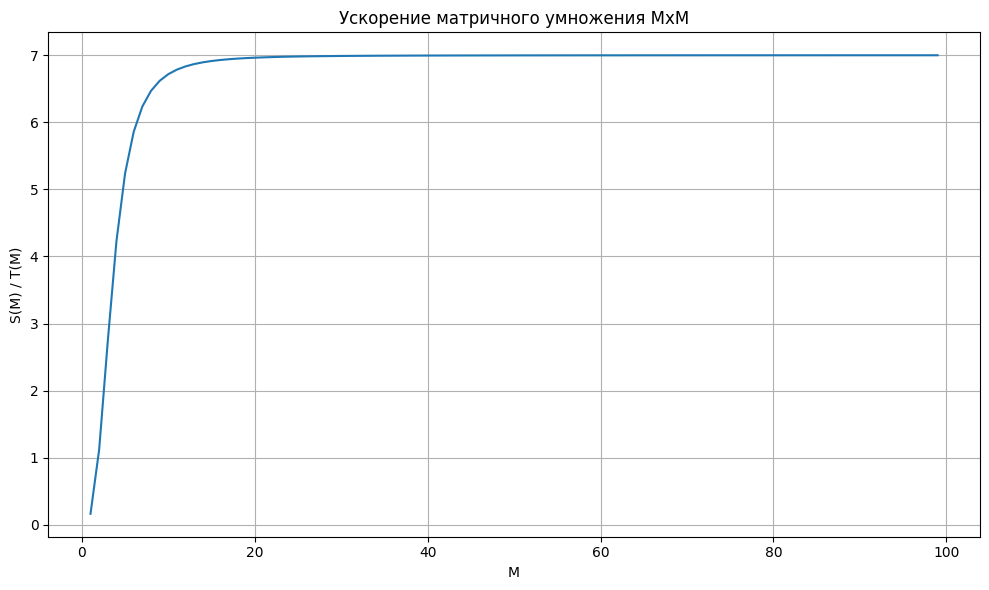

In [13]:
m = np.arange(1, 100)

plt.figure(figsize=(10, 6))
plt.plot(m, time_single(m) / time_parallel(m))

plt.title("Ускорение матричного умножения MxM")
plt.xlabel("M")
plt.ylabel("S(M) / T(M)")
plt.grid()
plt.tight_layout()

plt.show()

### Выводы

Ленточный алгоритм даёт хорошее ускорение для матриц большого размера ($M>10$)

## Задание 3. Исследование ассоциативного процессора

In [14]:
def format_bin(n, d):
    return format(n, f"0{d}b")


memory = [(randint(0, 15), randint(0, 255)) for _ in range(d.cell_count)]

display_table(
    [
        [i, format_bin(tag, 4), tag, format_bin(data, 8), data]
        for i, (tag, data) in enumerate(memory)
    ],
    ["№", "Тег (бин.)", "Тег (дес.)", "Данные (бин.)", "Данные (дес.)"],
)

№,Тег (бин.),Тег (дес.),Данные (бин.),Данные (дес.)
0,0001,1,11001101,205
1,1000,8,01110000,112
2,1101,13,11101111,239
3,1101,13,10001101,141
4,1000,8,10010011,147
5,0011,3,11110011,243
6,0000,0,10110110,182
7,0100,4,00100110,38
8,0111,7,00010111,23
9,1100,12,11010000,208


### Ассоциативный признак

In [15]:
print(f"{d.assoc_tag=}")

d.assoc_tag=13


### Выполнение операции для ячеек с искомым ассоциативным признаком

In [16]:
display_table(
    [
        [
            i,
            tag,
            "+" if tag == d.assoc_tag else "",
            data,
            data + 1 if tag == d.assoc_tag else data,
        ]
        for i, (tag, data) in enumerate(memory)
    ],
    ["№", "Тег", "Совпадение", "Старые<br>данные", "Новые<br>данные"],
)

№,Тег,Совпадение,Старыеданные,Новыеданные
0,1,,205,205
1,8,,112,112
2,13,+,239,240
3,13,+,141,142
4,8,,147,147
5,3,,243,243
6,0,,182,182
7,4,,38,38
8,7,,23,23
9,12,,208,208


### Вычсление времени обработки

In [17]:
m = 8
t = 8
N = 1000
k = d.complexity


@np.vectorize
def assoc_time(n):
    return m * t * (N / n + k)


print(f"T={assoc_time(d.cell_count)} при n={d.cell_count}")

T=2477.714285714286 при n=28


### График зависимости времени обработки от числа ячеек

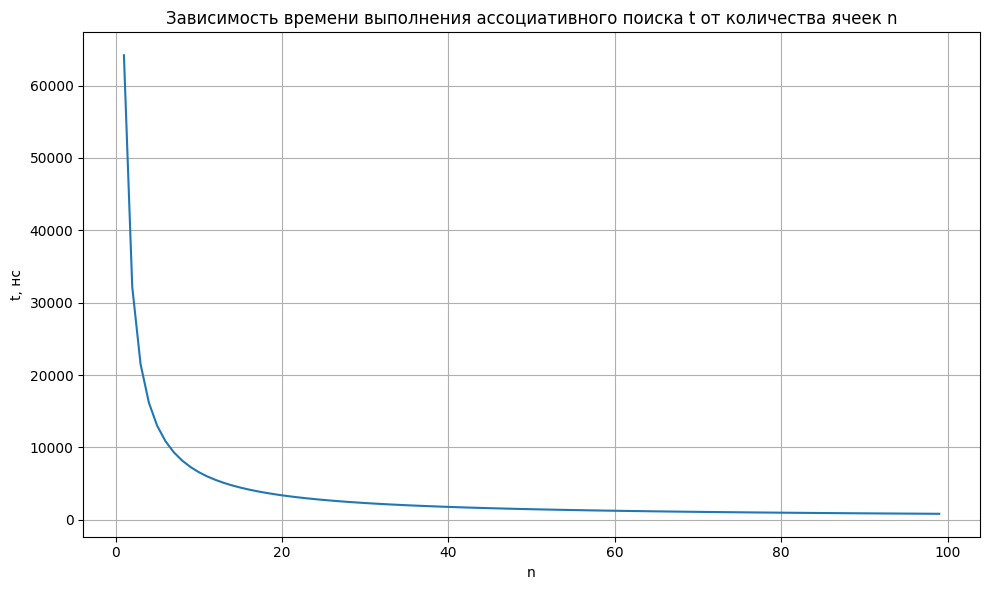

In [18]:
n = np.arange(1, 100)

plt.figure(figsize=(10, 6))
plt.plot(n, assoc_time(n))

plt.title(
    "Зависимость времени выполнения ассоциативного поиска t от количества ячеек n"
)
plt.xlabel("n")
plt.ylabel("t, нс")
plt.grid()
plt.tight_layout()

plt.show()

### График ускорения времени обработки при увеличении числа ячеек

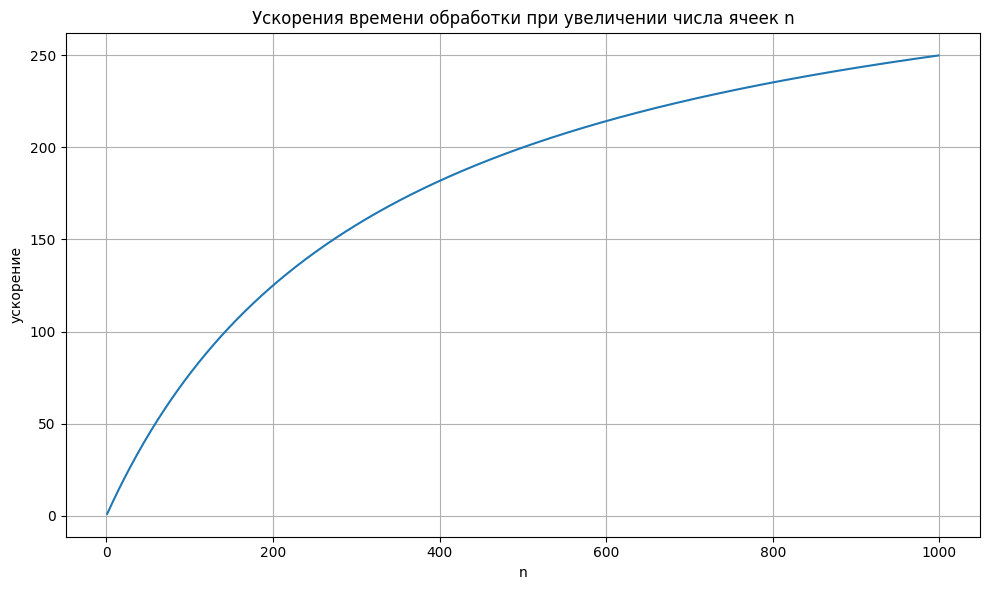

In [19]:
serial_time = N * m * t

n = np.arange(1, 1000)

plt.figure(figsize=(10, 6))
plt.plot(n, serial_time / assoc_time(n))

plt.title("Ускорения времени обработки при увеличении числа ячеек n")
plt.xlabel("n")
plt.ylabel("ускорение")
plt.grid()
plt.tight_layout()

plt.show()

### Выводы

Ассоциативный процессор справляется с обработкой информации быстрее, чем последовательный. Ускорение стремится к N при стремлении числа ячеек N и имеет асимптотику близкую к $\sqrt{n}$.

## Задание 4. Исследование систолического массива

### Схема линейного систолического массива

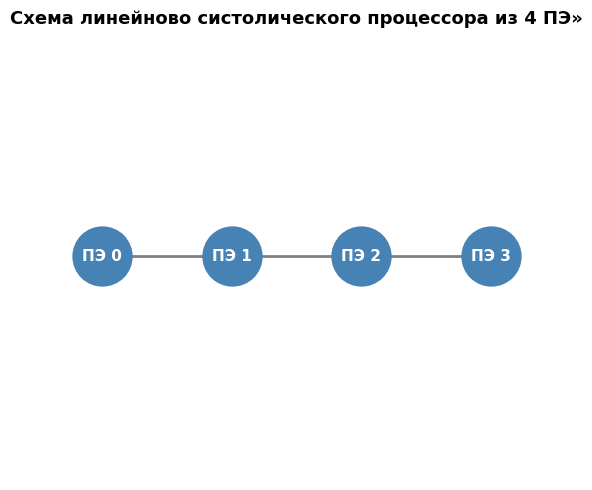

In [20]:
a = 1
b = d.systolic_array_size

G = nx.grid_2d_graph(a, b)
pos = {(i, j): (j, -i) for i, j in G.nodes()}
labels = {(i, j): f"ПЭ {i*b + j}" for i, j in G.nodes()}

plt.figure(figsize=(5, 5))
plt.title(
    f"Схема линейново систолического процессора из {b} ПЭ»",
    fontsize=13,
    fontweight="bold",
)

nx.draw(
    G,
    pos=pos,
    labels=labels,
    with_labels=True,
    node_color="steelblue",
    node_size=1800,
    font_color="white",
    font_size=11,
    font_weight="bold",
    edge_color="gray",
    width=2,
)

plt.tight_layout()
plt.savefig("matrix_simd.png", dpi=150)
plt.show()

### Таблица состояний ПЭ линейного систолического массива

| Такт | ПЭ₀ (b₀) | ПЭ₁ (b₁) | ПЭ₂ (b₂) | ПЭ₃ (b₃) | Готов результат |
|:----:|:---------:|:---------:|:---------:|:---------:|:---------------:|
|  0   | a₀·b₀     | —         | —         | —         | —               |
|  1   | a₁·b₀     | a₀·b₁     | —         | —         | —               |
|  2   | a₂·b₀     | a₁·b₁     | a₀·b₂     | —         | —               |
|  3   | a₃·b₀     | a₂·b₁     | a₁·b₂     | a₀·b₃     | **c₀**          |
|  4   | a₄·b₀     | a₃·b₁     | a₂·b₂     | a₁·b₃     | **c₁**          |
|  5   | a₅·b₀     | a₄·b₁     | a₃·b₂     | a₂·b₃     | **c₂**          |
|  6   | a₆·b₀     | a₅·b₁     | a₄·b₂     | a₃·b₃     | **c₃**          |
|  7   | a₇·b₀     | a₆·b₁     | a₅·b₂     | a₄·b₃     | **c₄**          |
|  8   | —         | a₇·b₁     | a₆·b₂     | a₅·b₃     | **c₅**          |
|  9   | —         | —         | a₇·b₂     | a₆·b₃     | **c₆**          |
| 10   | —         | —         | —         | a₇·b₃     | **c₇**          |
| 11   | —         | —         | —         | —         | **c₈, c₉, c₁₀**|


### Расчёт производительности гексагонального систолического массива

In [21]:
@np.vectorize
def time_sitlolic(l):
    return 3 * l - 2


@np.vectorize
def time_single(l):
    return l**3


t = time_sitlolic(d.systolic_array_size)
s = time_single(d.systolic_array_size)
a = s / t

print(f"При L={d.systolic_array_size}:")
print()

print("Время параллельного умножения матриц LxL:")
print(f"T(L) = {t}")
print()

print("Время однопроцессорного умножения матриц LxL")
print(f"S(L) = {s}")
print()

print("Ускорение:")
print(f"S(L) / T(L) = {a}")

При L=4:

Время параллельного умножения матриц LxL:
T(L) = 10

Время однопроцессорного умножения матриц LxL
S(L) = 64

Ускорение:
S(L) / T(L) = 6.4


### График зависимости ускорения гексагонального ситлолического массива от размера

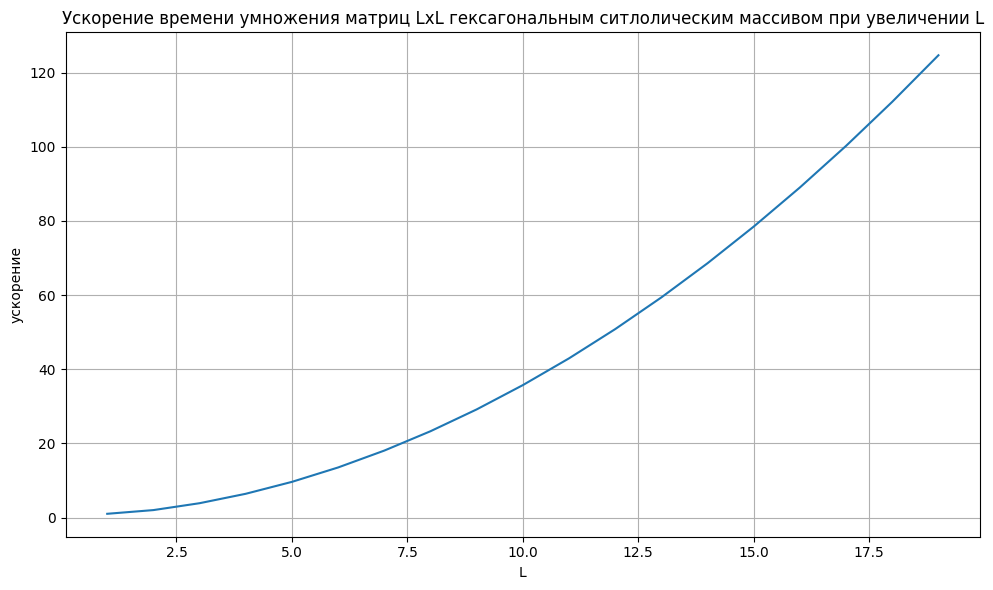

In [22]:
l = np.arange(1, 20)

plt.figure(figsize=(10, 6))
plt.plot(l, time_single(l) / time_sitlolic(l))

plt.title(
    "Ускорение времени умножения матриц LxL "
    "гексагональным ситлолическим массивом при увеличении L"
)
plt.xlabel("L")
plt.ylabel("ускорение")
plt.grid()
plt.tight_layout()

plt.show()

### Выводы

Ситлолические массивы позволяют значительно ускорить вычисления с векторами и матрицами, при чём прирост скорости неограничен и имеет квадратичную асимптотику

## Задание 5. Сравнительный анализ архитектур SIMD


### Сводная таблица характеристик

| Характеристика | Векторно-конвейерная | Матричная | Ассоциативная | Систолическая |
|---|---|---|---|---|
| **Принцип обработки** | Элементы вектора проходят через конвейер — каждый этап выполняет одну операцию | Одна команда выполняется одновременно на всех ПЭ прямоугольной решётки (чистый SIMD) | Параллельный поиск/обработка по содержимому во всех ячейках CAM-памяти | Данные ритмично «перекачиваются» между ПЭ; каждый ПЭ выполняет фиксированную операцию над потоком |
| **Тип параллелизма** | Конвейерный (временной) + векторный | Пространственный (массовый SIMD) | Ассоциативный (параллелизм по данным с условием) | Пространственно-временной (волновой фронт) |
| **Организация памяти** | Векторные регистры + банки с чередованием адресов для бесконфликтного доступа | Распределённая: каждый ПЭ имеет локальную память; обмен через сеть межсоединений | CAM (Content-Addressable Memory) — адресация по значению, а не по месту | Локальная память ПЭ минимальна; данные хранятся «в движении» между ПЭ |
| **Область применения** | Научные вычисления, линейная алгебра, обработка сигналов, CFD | Обработка изображений, матричные операции, нейросетевые вычисления | Поиск по БД, сопоставление с образцом, таблицы маршрутизаторов | Матричное умножение, LU-разложение, ЦОС, VLSI-вычисления |
| **Преимущества** | Высокая пропускная способность на длинных векторах; гибкость типов данных; зрелые компиляторы | Максимальный параллелизм при регулярных задачах; простое масштабирование | Поиск за O(1) независимо от объёма; параллельная обработка всех записей | Регулярный поток без накладных расходов на коммуникацию; высокая энергоэффективность |
| **Недостатки** | Латентность заполнения конвейера; неэффективен на коротких векторах | Жёсткая синхронизация всех ПЭ; низкая эффективность при нерегулярных задачах | Высокая стоимость CAM-аппаратуры; ограниченный объём памяти | Жёсткая топология; применим только к регулярным алгоритмам |
| **Примеры систем** | Cray-1, NEC SX-9, Intel AVX/SSE, NVIDIA GPU (векторные блоки) | CM-2 (Connection Machine), ILLIAC IV, Goodyear MPP, TPU (матричные блоки) | STARAN, CAAPP, CAM в сетевых коммутаторах (Cisco, Juniper) | Google TPU v1, Intel Nervana, FPGA Xilinx, Systolic Array (Kung & Leiserson) |

### Анализ применимости для различных задач

**1. Умножение больших плотных матриц → Систолическая**
Элементы матриц A и B «протекают» сквозь решётку ПЭ в противоположных направлениях, каждый ПЭ накапливает частичные суммы. Максимальное повторное использование данных без обращений к памяти — O(N²) вычислений при O(N) пересылок. Именно этот принцип реализован в Google TPU.

**2. Обработка изображений (фильтрация, свёртка) → Матричная**
Изображение — прямоугольная сетка пикселей, идеально совпадающая с топологией ПЭ-ПЭ. Каждый ПЭ обрабатывает один пиксель, применяя ядро свёртки одновременно. Локальные связи между соседними ПЭ обеспечивают доступ к окрестности без глобальной памяти.

**3. Поиск по образцу в базе данных → Ассоциативная**
Образец-запрос подаётся одновременно во все ячейки, каждая за один такт сравнивает своё содержимое и выдаёт маску совпадений — O(1) независимо от размера базы. Матричная и векторная архитектуры потребовали бы многократных проходов по данным.

**4. Быстрое преобразование Фурье (FFT) → Векторно-конвейерная**
FFT имеет регулярную структуру «бабочки», хорошо выражающуюся векторными операциями (умножение на поворачивающие множители, сложение/вычитание). Конвейер загружается однородными операциями над длинными векторами с максимальной пропускной способностью (Cray, NEC SX, cuFFT).

**5. Решение СЛАУ → Систолическая** (плотные) **/ Векторно-конвейерная** (разреженные)
Для плотных матриц методом Гаусса или LU-разложения оптимален систолический массив: операция обновления строк (rank-1 update) — классический систолический паттерн (алгоритм Кунга–Лейзерсона, 1978). Для разреженных СЛАУ с нерегулярной структурой предпочтительнее векторно-конвейерная архитектура с гибким доступом к памяти.

# Вывод

В ходе лабораторной работы были исследованы четыре основных класса SIMD-архитектур: векторно-конвейерная, матричная, ассоциативная и систолическая. Для каждой архитектуры были рассчитаны показатели производительности и построены графики зависимости времени выполнения и ускорения от размера входных данных. Показано, что векторно-конвейерная обработка даёт ускорение, стремящееся к 2 при увеличении длины вектора; матричный процессор обеспечивает ускорение, близкое к числу процессорных элементов при достаточно больших матрицах; ассоциативный процессор демонстрирует ускорение с асимптотикой, близкой к √n; а систолический массив показывает квадратичный рост ускорения с увеличением размера массива L.

Сравнительный анализ архитектур позволил установить область применения каждой из них: векторно-конвейерные системы наиболее эффективны для задач FFT и обработки сигналов, матричные — для обработки изображений и свёрток, ассоциативные — для поиска по содержимому в базах данных, систолические — для умножения плотных матриц и решения СЛАУ. Таким образом, выбор архитектуры существенно зависит от структуры решаемой задачи: регулярность алгоритма, объём входных данных и характер доступа к памяти являются ключевыми критериями при проектировании высокопроизводительных вычислительных систем класса SIMD.